# Which genes are turned on/off in some cancers but not others?

importing IPython notebook from DX_screen

importing IPython notebook from Imports

importing IPython notebook from Setup/DX_Imports

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


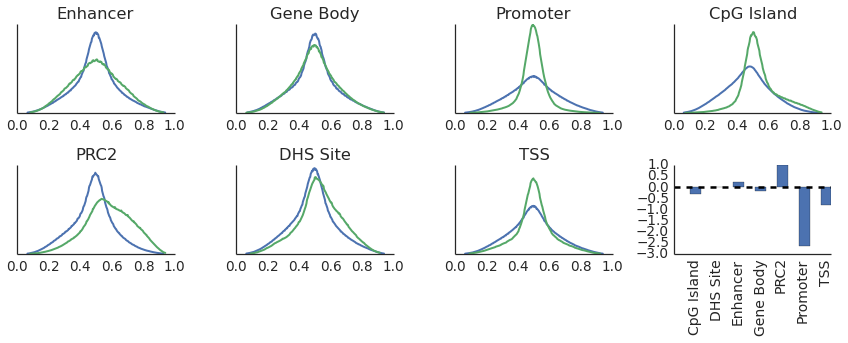

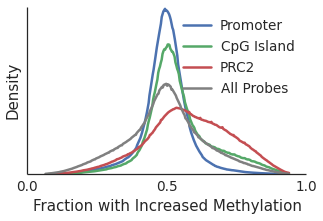

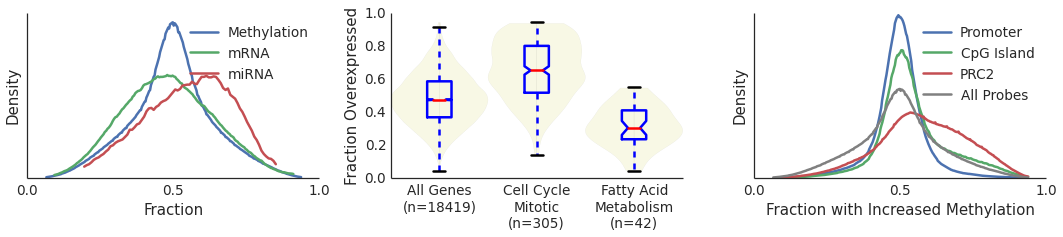

In [1]:
import NotebookImport
from DX_screen import *

In [2]:
from Figures.Regression import *

In [3]:
def dx_group(split, matched_tn, fc=1.):
    tab_1 = binomial_test_screen(matched_tn.ix[:, ti(split==True)], fc=fc)
    tab_1 = tab_1.ix[(((tab_1.frac - .5).abs() > .25) & (tab_1.p > .001)) == False]
    
    tab_0 = binomial_test_screen(matched_tn.ix[:, ti(split==False)], fc=fc)
    tab_0 = tab_0.ix[(((tab_0.frac - .5).abs() > .25) & (tab_0.p > .001)) == False]
    
    #df = matched_tn.ix[:, ti(split==True)]
    #ttest_1 = df.apply(ttest_rel, axis=1)
    
    #df = matched_tn.ix[:, ti(split==False)]
    #ttest_0 = df.apply(ttest_rel, axis=1)
    
    t0 = tab_0
    t1 = tab_1
    t = pd.concat([t0, t1], keys=['miss','hit'], axis=1)
    return t

In [4]:
matched_meth.shape

(396065, 1408)

In [5]:
vc = codes.ix[matched_meth.columns.get_level_values(0).unique()].value_counts()
vc.sum()

676

In [6]:
cancers = ti(vc > 30)

In [7]:
dx = {c: dx_group(codes==c, matched_meth) for c in cancers}
dx = pd.concat(dx, axis=1)
dx = dx.ix[dx_meth.index]

In [8]:
t_m = dx.xs(('miss','frac'), axis=1, level=[1,2])
t_h = dx.xs(('hit','frac'), axis=1, level=[1,2])
num_dx = dx.xs(('hit','num_dx'), axis=1, level=[1,2])
t_m = t_m.mask(num_dx < 30)

In [9]:
mag_frac = lambda f: (f - .5).abs()

In [10]:
v = (mag_frac(t_m) - mag_frac(t_h)) * (p < .01)
v = v.stack().order()

In [11]:
len(cancers)

10

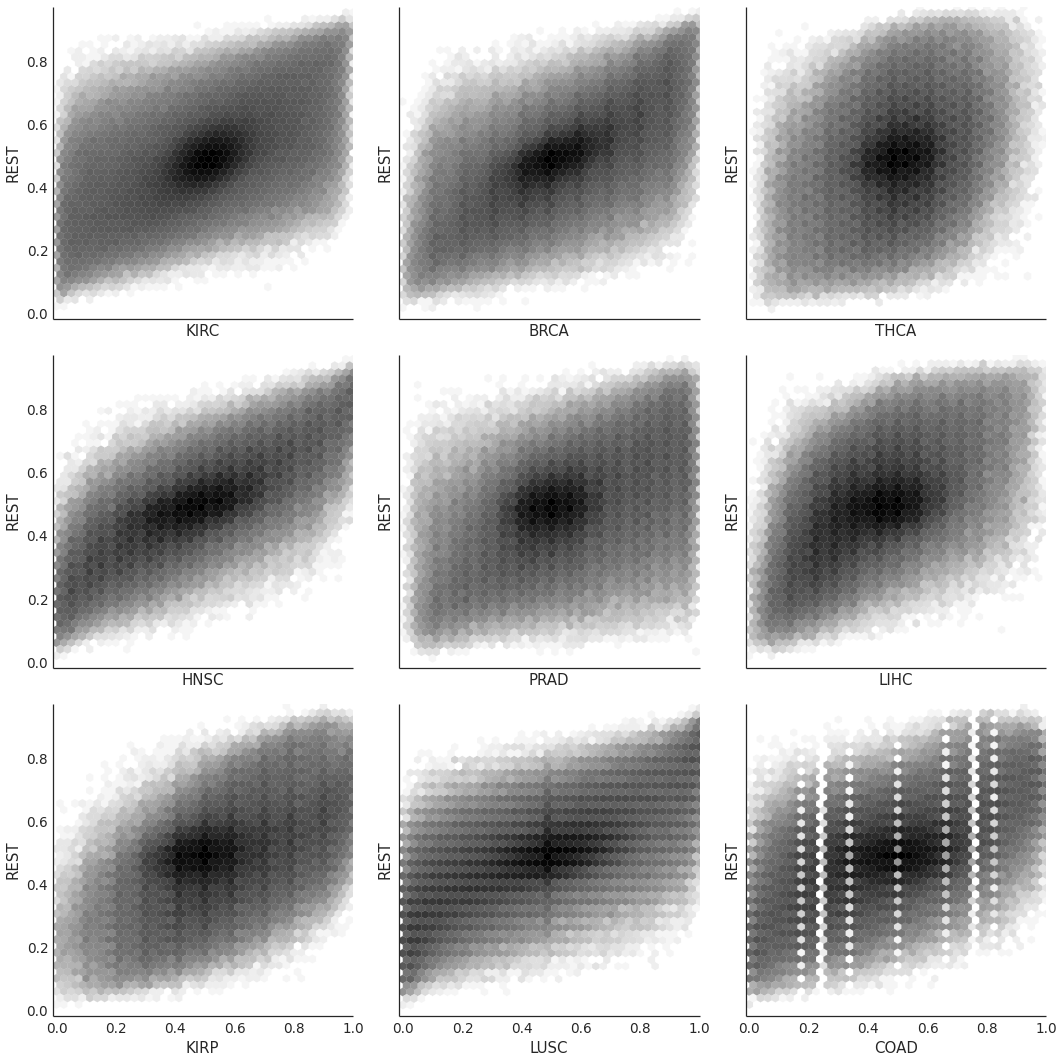

In [12]:
fig, axs = subplots(3,3, figsize=(15,15), sharex=True, sharey=True)
axs = axs.flatten()
for i,c in enumerate(cancers[:9]):
    ax = axs[i]
    s1, s2 = match_series(t_h[c].dropna(), t_m[c].dropna())
    fig, ax = init_ax(ax, figsize=(5, 5))
    ax.hexbin(s1, s2, gridsize=40, bins='log')

    ax.set_xlabel(c)
    ax.set_ylabel('REST');
sns.despine(fig)
fig.tight_layout()

In [13]:
count = vc.head(9)
count.name = 'count'

reg = pd.DataFrame({c: linear_regression(t_h[c].dropna(), t_m[c]) for c in t_m}).T
reg = reg.join(count)
reg.sort('r-value')

,intercept,p-value,r-value,slope,stderr,count
THCA,0.33,0,0.31,0.32,1.57e-03,56
PRAD,0.30,0,0.48,0.35,1.01e-03,49
KIRP,0.27,0,0.53,0.39,9.87e-04,45
LIHC,0.31,0,0.55,0.46,1.11e-03,47
KIRC,0.32,0,0.56,0.36,8.62e-04,159
COAD,0.33,0,0.56,0.36,8.61e-04,37
UCEC,0.34,0,0.58,0.35,8.23e-04,NaN
BRCA,0.26,0,0.63,0.43,8.39e-04,90
LUSC,0.33,0,0.65,0.36,6.71e-04,40
HNSC,0.28,0,0.75,0.47,6.57e-04,50


In [14]:
c = 'BRCA'
adjusted = {}
for c in cancers:
    vec = t_h[c]
    order = t_m[c].order().dropna()
    vec = vec.ix[order.index].dropna()
    mm = pd.rolling_mean(vec, 1000, center=True)
    ss = pd.rolling_std(vec, 1000, center=True)
    zz = ((vec - mm) / ss).dropna()
    reg = linear_regression(order, zz)
    zz = (zz - ((order * reg['slope'])  + reg['intercept'])).dropna()
    adjusted[c] = zz
adjusted = pd.concat(adjusted, axis=1)

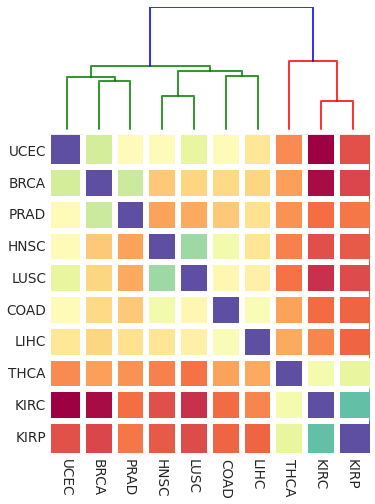

In [15]:
d = adjusted.dropna()
d = d[d.std(1).rank(pct=True) > .95]
fancy_raster(d.corr(), cluster=True)

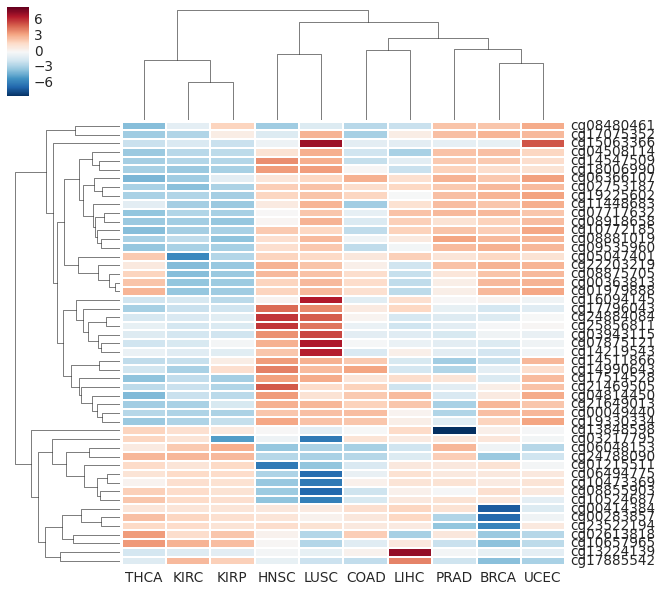

In [16]:
d = adjusted.dropna()
d = d[d.std(1).rank(pct=True) > .99985]
sns.clustermap(d)
#plt.gcf().savefig('/cellar/users/agross/figures/cancer_cluster2.png', dpi=300)

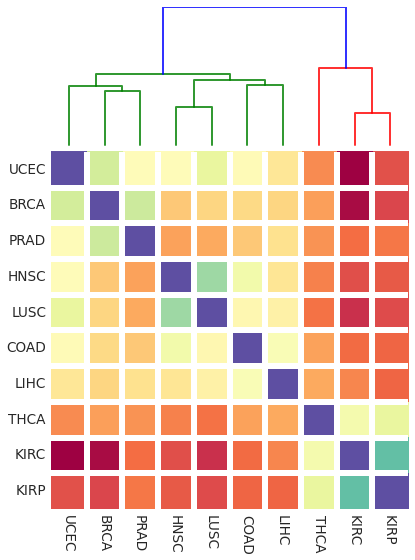

In [17]:
d = adjusted.dropna()
d = d[d.std(1).rank(pct=True) > .95]
fancy_raster(d.corr(), cluster=True)
plt.gcf().tight_layout()
plt.gcf().savefig('/cellar/users/agross/figures/cancer_cluster.png', dpi=300)

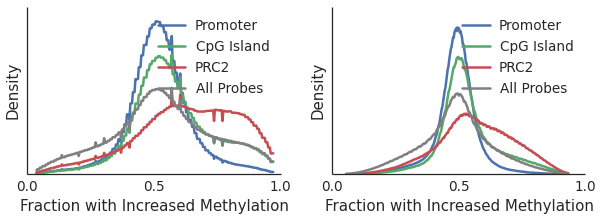

In [18]:
def meth_dist(v, ax):
    lw = 2.5
    draw_dist(v.ix[ti(DX.probe_sets['Promoter'])].dropna(), ax=ax, lw=lw, bins=300)
    draw_dist(v.ix[ti(DX.probe_sets['CpG Island'])], ax=ax, lw=lw, bins=300)
    draw_dist(v.ix[ti(DX.probe_sets['PRC2'])], ax=ax, lw=lw, bins=300)
    draw_dist(v, ax=ax, colors='grey', lw=lw, bins=300)
    ax.set_yticks([])
    ax.set_xticks([0,.5,1])
    ax.set_ylabel('Density')
    ax.set_xlabel('Fraction with Increased Methylation')
    ax.legend(('Promoter','CpG Island','PRC2','All Probes'))
    prettify_ax(ax)
    return ax

fig, axs = subplots(1,2, figsize=(10,3))
v = dx[('BRCA','hit','frac')]
meth_dist(v, axs[0]);
v = dx[('BRCA','miss','frac')]
meth_dist(v, axs[1]);

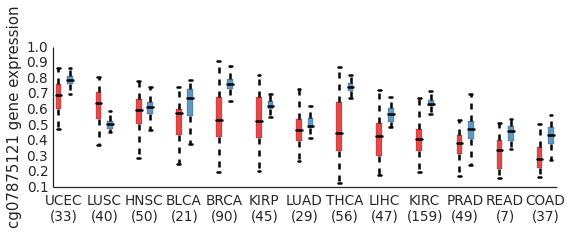

In [19]:
paired_bp_tn_split(matched_meth.ix['cg07875121'], codes)

In [20]:
def odds_ratio_df(a,b):
    a = a.astype(int)
    b = b.astype(int)
    flip = lambda v: (v == 0).astype(int)

    a11 = (a.add(b) == 2).sum(axis=1)
    a10 = (a.add(flip(b)) == 2).sum(axis=1)
    a01 = (flip(a).add(b) == 2).sum(axis=1)
    a00 = (flip(a).add(flip(b)) == 2).sum(axis=1)
    odds_ratio = (1.*a11 * a00) / (1.*a10 * a01)
    df = pd.concat([a00, a01, a10, a11], axis=1,
                   keys=['00','01','10','11'])
    return odds_ratio, df

In [21]:
dr = (matched_meth.xs('01',1,1) > matched_meth.xs('11',1,1)) * 1.
dr = dr.ix[ti(dx_meth.num_dx > 200)].dropna()
dr = dr.ix[:, codes.index.intersection(dr.columns)]

In [22]:
odds_ratio = {}
df_odds_ratio = {}
for c in cancers:
    cc = (codes == c).ix[dr.columns]
    odds_ratio[c], df_odds_ratio[c] = odds_ratio_df(dr, cc)
odds_ratio = pd.concat(odds_ratio, 1)
df_odds_ratio = pd.concat(df_odds_ratio, 1)

In [23]:
log_odds = np.log2(odds_ratio).clip(-6,6)

In [24]:
log_odds.head()

,BRCA,COAD,HNSC,KIRC,KIRP,LIHC,LUSC,PRAD,THCA,UCEC
Hybridization REF,,,,,,,,,,
cg00000029,0.42,-1.98,-0.03,1.92,0.04,0.71,-0.18,-0.09,-1.74,-1.75
cg00000165,0.24,0.10,3.39,-0.28,-1.38,-1.11,4.07,0.87,-2.94,1.20
cg00000236,1.43,-0.83,0.21,-1.01,0.49,0.77,-0.62,0.16,0.31,1.37
cg00000289,0.60,-0.61,1.77,-0.37,0.49,-0.32,-1.74,-0.17,-0.30,0.80
cg00000292,-0.79,-0.23,-0.07,0.50,1.60,0.01,-1.10,0.95,0.60,-1.16


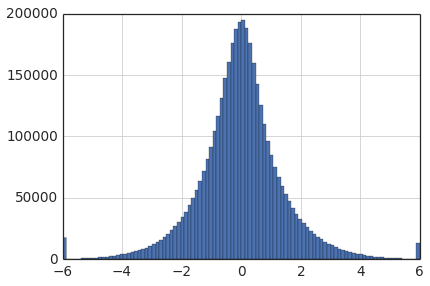

In [25]:
log_odds.stack().hist(bins=100)

In [26]:
def fet(s):
    odds, p = stats.fisher_exact([[s['00'],s['01']],
                                  [s['10'],s['11']]])
    return p

In [27]:
d2 = df_odds_ratio.unstack().unstack(1)
o2 = log_odds.T.stack()

In [28]:
(d2[o2.abs() == 6]).shape

(29956, 4)

In [29]:
%time p = d2[o2.abs() > 5].head(1000).apply(fet, 1).order()

CPU times: user 14.4 s, sys: 279 µs, total: 14.4 s
Wall time: 14.5 s


In [30]:
o2 = o2.ix[o2.index.diff(p[p < .05].index)]

In [31]:
log_odds_f = o2.order().unstack().T

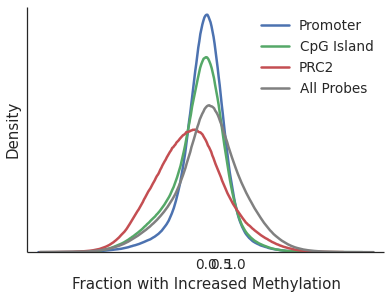

In [32]:
fig, ax = subplots()
meth_dist(log_odds.THCA, ax);

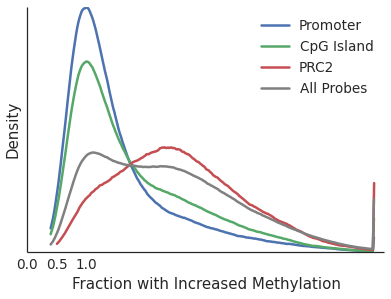

In [33]:
fig, ax = subplots()
meth_dist(log_odds.abs().max(1), ax);

In [34]:
d = log_odds.ix[ti(DX.probe_sets['PRC2'])].dropna()
(d > 3).sum().order()

THCA     190
LIHC     193
KIRC    1110
BRCA    1270
KIRP    1347
UCEC    2652
HNSC    3245
COAD    4547
PRAD    4857
LUSC    5079
dtype: int64

In [35]:
d = log_odds.ix[ti(DX.probe_sets['Promoter'])].dropna()
(d > 3).sum().order()

THCA      48
LIHC     206
KIRC     260
HNSC     405
KIRP     431
BRCA     534
LUSC     665
COAD     718
UCEC     843
PRAD    2267
dtype: int64

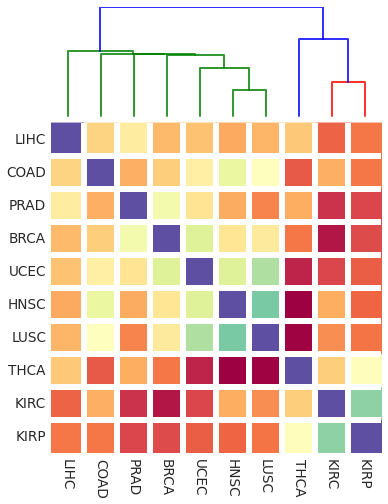

In [36]:
lo = log_odds[log_odds.std(1).rank(pct=True) > .95]
fancy_raster(lo.corr(), cluster=True)